Import the required libraries

In [1]:
# Data

import numpy as np
from sklearn.datasets        import load_iris, make_moons
from sklearn.model_selection import train_test_split

# Visualization

import seaborn           as sns
import matplotlib.pyplot as plt

# ML model

import torch
import torch.nn            as nn
import torch.optim         as optim
import torch.nn.functional as F

from torch_geometric.data   import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn     import MessagePassing
from torch_geometric.utils  import add_self_loops, degree
from torch.utils.data       import random_split
from torch.nn               import Linear
from torch_geometric.nn     import GraphConv
from torch_geometric.nn     import global_mean_pool

# External library
import ML_library as ML

# Set seaborn environmet (for plotting)
sns.set_theme()

# Set random seed for reproducibility
torch.manual_seed(12345)

# Neural Network:
### Iris dataset

Basic neural network parameters

In [2]:
num_epochs    = 100
batch_size    = 16
learning_rate = 0.01

Load the Iris dataset

In [3]:
iris     = load_iris()
features = iris.data
labels   = iris.target

Split the dataset into training and testing sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

Convert the data to PyTorch tensors

In [5]:
X_train = torch.Tensor(X_train)
X_test  = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test  = torch.LongTensor(y_test)

Visualize the data

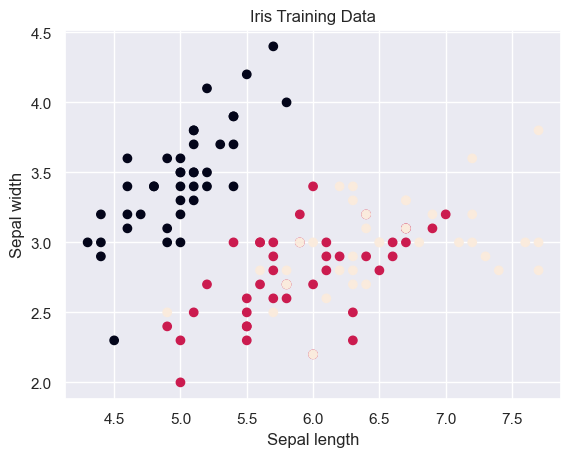

In [6]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

Define the neural network architecture

In [7]:
class NeuralNetwork(nn.Module):
    """Dense Neural Network with one hidden layer, with RELU activation function.
    """
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4,  10)  # Fully connected layer 1
        self.fc2 = nn.Linear(10, 10)  # Fully connected layer 2
        self.fc3 = nn.Linear(10,  3)  # Output layer with 3 classes
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to fc1
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to fc2
        x = self.fc3(x)  # Output layer does not have an activation function
        return x

Create an instance of the neural network

In [8]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


Define the loss function and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Training the neural network

In [11]:
losses = []
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs  = X_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    losses.append(loss.item())

Epoch: 10/100, Loss: 1.064892053604126
Epoch: 20/100, Loss: 1.0303959846496582
Epoch: 30/100, Loss: 0.9732910394668579
Epoch: 40/100, Loss: 0.8658252954483032
Epoch: 50/100, Loss: 0.7247447967529297
Epoch: 60/100, Loss: 0.6065261363983154
Epoch: 70/100, Loss: 0.506075918674469
Epoch: 80/100, Loss: 0.42690202593803406
Epoch: 90/100, Loss: 0.35902029275894165
Epoch: 100/100, Loss: 0.29379159212112427


Plot the loss curve

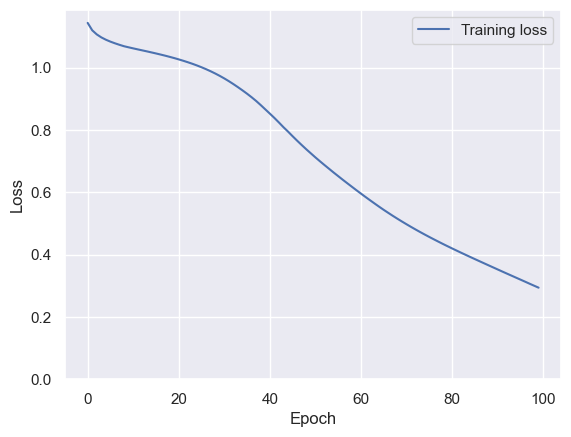

In [12]:
plt.plot(losses, label='Train loss')
plt.ylim(bottom=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

Evaluating the model

In [15]:
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f'Accuracy on test set: {accuracy}')

Accuracy on test set: 0.8333333333333334


# Equivariant Graph Neural Network:
### Ground state energy prediction

Basic neural network parameters

In [16]:
n_epochs      = 100
batch_size    = 128
learning_rate = 0.0001
dropout       = 0.4

Load graph database for training. If it was already normalized, that dataset is loaded. Otherwise, we have to nomalized it (very time costly).

In [17]:
dataset_name        = 'dataset.pt'
dataset_name_std    = 'standardized_dataset.pt'
parameters_name_std = 'standardized_parameters.pt'  # Parameters for rescaling the predictions

try:
    # Load normalized data
    dataset    = torch.load(dataset_name_std)
    parameters = torch.load(parameters_name_std)

    # Assign parameters accordingly
    target_mean, feat_mean, edge_mean, target_std, edge_std, feat_std = parameters

except FileNotFoundError:
    # Load non-normalized data
    dataset = torch.load(dataset_name)

    # Initialized lists
    target_list = torch.tensor([])
    edge_list   = torch.tensor([])
    feat_mean   = torch.tensor([])
    feat_std    = torch.tensor([])

    # Stack all graphs
    for data in dataset:
        target_list = torch.cat((target_list, data.y),         0)
        edge_list   = torch.cat((edge_list,   data.edge_attr), 0)

    # Compute means and standard deviations
    target_mean = torch.mean(target_list)
    edge_mean   = torch.mean(edge_list)
    target_std  = torch.std(target_list)
    edge_std    = torch.std(edge_list)

    # Update normalized values into the database
    for data in dataset:
        data.y         = (data.y         - target_mean) / target_std
        data.edge_attr = (data.edge_attr - edge_mean)   / edge_std

    # Update normalized values into the database
    for feat_index in range(dataset[0].num_node_features):
        feat_list = torch.tensor([])

        for data in dataset:
            feat_list = torch.cat((feat_list, data.x[:, feat_index]), 0)

        feat_mean = torch.cat((feat_mean, torch.tensor([torch.mean(feat_list)])), 0)
        feat_std  = torch.cat((feat_std,  torch.tensor([torch.std(feat_list)])),  0)

        for data in dataset:
            data.x[:, feat_index] = (data.x[:, feat_index] - feat_mean[feat_index]) / feat_std[feat_index]
    
    # Define list of parameters
    parameters = [target_mean, feat_mean, edge_mean, target_std, edge_std, feat_std]
    
    # Save standarized dataset
    torch.save(dataset,    dataset_name_std)
    torch.save(parameters, parameters_name_std)

Define train and test sets. If it is aimed to do hyperparameters optimization, a validation must be as well defined.

In [18]:
# Define the sizes of the train and test sets
train_size = int(0.9 * len(dataset))
test_size  = len(dataset) - train_size

# Use random_split() to generate train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of testing  graphs: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size,        shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=True)

Number of training graphs: 23720
Number of testing  graphs: 2636


Define the neural network architecture

In [19]:
class GCNN(torch.nn.Module):
    """Graph Convolution Neural Network, with RELU activation function.
    """
    
    def __init__(self, features_channels, pdropout=0.4):
        super(GCNN, self).__init__()
        
        # Define graph convolution layers
        self.conv1   = GraphConv(features_channels, 256)
        self.conv2   = GraphConv(256, 256)
        
        # Define linear layers
        self.linconv = Linear(256, 16)
        self.lin     = Linear(16, 1)
        
        self.pdropout = pdropout

    def forward(self, x, edge_index, edge_attr, batch):
        ## CONVOLUTION
        
        # Apply graph convolution with ReLU activation function
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()

        ## POOLING
        
        # Apply global mean pooling to reduce dimensionality
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # Apply dropout regularization
        
        x = F.dropout(x, p=self.pdropout, training=self.training)
        
        # Apply linear convolution with ReLU activation function
        x = self.linconv(x)
        x = x.relu()
        
        ## REGRESSION
        
        # Apply final linear layer to make prediction
        x = self.lin(x)
        return x

Create an instance of the neural network

*num_node_features*: extracts from one graph the number features defined for each atom.

In [20]:
model = GCNN(features_channels=dataset[0].num_node_features,
             pdropout=dropout)
print(model)

GCNN(
  (conv1): GraphConv(5, 256)
  (conv2): GraphConv(256, 256)
  (linconv): Linear(in_features=256, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)


Define training loop.

In [ ]:
# MSELoss is by default defined as the mean within the batch
# Thus, every batch contributes the same to the loss regardless of their shape (might be somenthing to change)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize all lists for extracting training results and train the model

train_losses = []
test_losses  = []
for epoch in range(n_epochs):
    train_loss, train_predictions, train_ground_truths = ML.train(model, criterion, train_loader, optimizer)
    test_loss,  test_predictions,  test_ground_truths  =  ML.test(model, criterion, test_loader)
    
    # Append losses
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    # Show results for some cases
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{n_epochs}, Train loss: {train_loss}, Test loss: {test_loss}")

Plot the last prediction

In [ ]:
# Stack train-test predictions and ground truths
stack = np.concatenate([train_predictions, train_ground_truths,
                        test_predictions,  test_ground_truths])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.figure(figsize=(5, 5))
plt.plot(train_predictions, train_ground_truths, '.', label='Train set')
plt.plot(test_predictions,  test_ground_truths,  'o', label='Test  set')
plt.xlabel(f'Predicted')
plt.ylabel(f'Computed')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.show()

Plot loss function over each training step

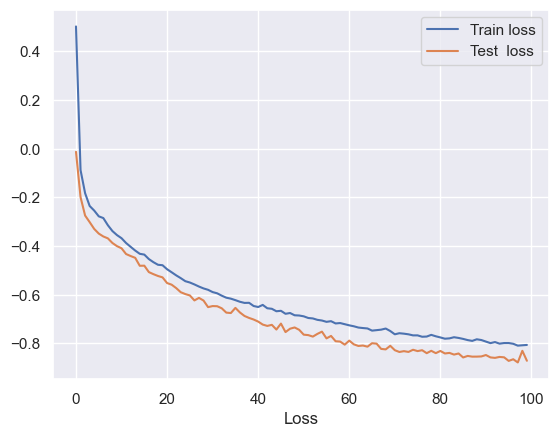

In [7]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(test_losses) , label='Test  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()